# Project 23 : FEATURE ALIGNMENT FOR UNPAIRED INFRARED IMAGE TRANSLATION IN THE MICROSTRUCTURES OF COMPOSITE MATERIALS
02456 DEEP LEARNING, DTU COMPUTE, FALL 2025 - Danish Technical University (DTU)
Authors : GROUP 130
  - Rémi Berthelot (s254144)
  - Andreas Løvendahl Eefsen (s224223)
  - Pierre Hollebèque (s254136)
  - Maxime Roux (s244314)

**In this notebook, we are simply going through the steps of the code without executing them on the entire dataset. We will use a few images as examples to illustrate the process.**

A more detailed tutorial on how to use the code can be found in the `README.md`.

The method has been tested with a part of the ImageNet dataset. This proof of concept model has been trained during 3 epochs. The losses are presented in appendix of this notebook. Here is the reconstructed upscaled version of an image taken from this dataset.
![Image Net Results](images/imagenet_results.png)

## Processing

The images in the dataset are divided into two categories: low-resolution images and high-resolution images.

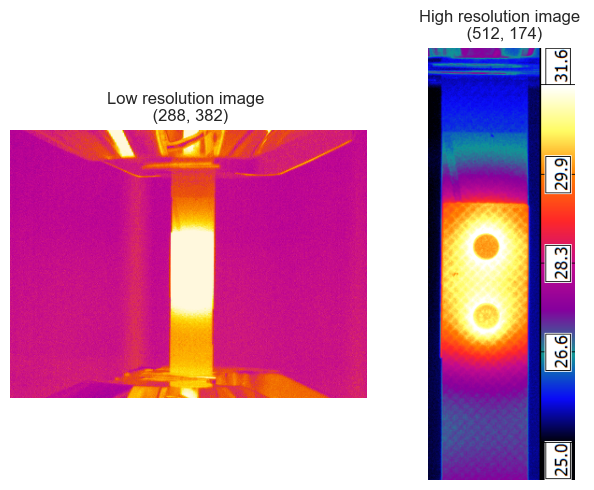

In [32]:
import matplotlib.pyplot as plt
from util.data_cropper_average import crop_relevant_zone, reformate_size
import matplotlib.image as mpimg

in_size = (40, 128)
out_size = (80, 256)


low_dataset_path = 'datasets/data_original/CFRP_60_low'
high_dataset_path = 'datasets/data_original/CFRP_60_high'

high_name = 'prst_A_stat_03_5_230149.png'
low_name = 'Record_2025-11-11_10-42-17.tiff'

img1= mpimg.imread(f"{low_dataset_path}/{low_name}")
img2= mpimg.imread(f"{high_dataset_path}/{high_name}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5))

ax1.imshow(img1)
ax1.set_title(f"Low resolution image \n {img1.shape[:2]}")
ax1.axis('off')  

ax2.imshow(img2)
ax2.set_title(f"High resolution image \n {img2.shape[:2]}")
ax2.axis('off')

plt.tight_layout()
plt.show()



The first step is to determine the region of interest (ROI). We cannot simply crop with fixed pixel positions because the specimens deform slightly during the experiments. To do this, we apply a significant Gaussian blur and then determine the point of maximum intensity. This code is implemented in the file `util/data_cropper_average.py`.

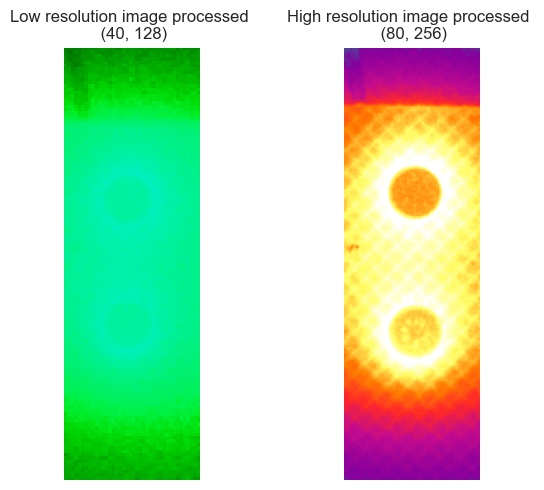

In [33]:
low_processed = crop_relevant_zone(f"{low_dataset_path}/{low_name}", in_size, tiff=True)
high_processed = crop_relevant_zone(f"{high_dataset_path}/{high_name}", out_size, tiff=False)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5))

ax1.imshow(low_processed)
ax1.set_title(f"Low resolution image processed \n {low_processed.size}")
ax1.axis('off')  

ax2.imshow(high_processed)
ax2.set_title(f"High resolution image processed \n {high_processed.size}")
ax2.axis('off')

plt.tight_layout()
plt.show()

The rest of the method uses square images. To convert rectangular images to square ones, we add black bands on both sides.

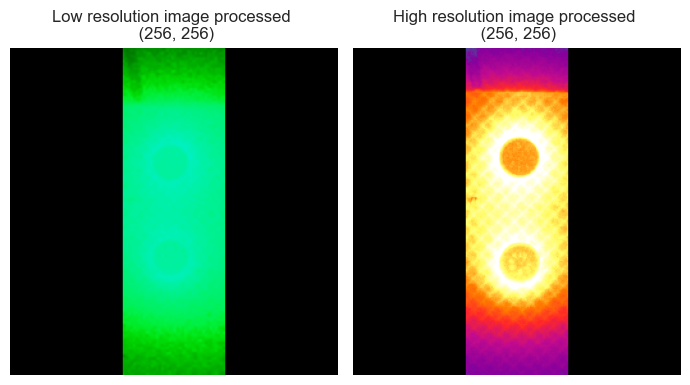

In [34]:
low_processed = reformate_size(low_processed, (256,256))
high_processed = reformate_size(high_processed, (256,256))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5))

ax1.imshow(low_processed)
ax1.set_title(f"Low resolution image processed \n {low_processed.size}")
ax1.axis('off')  

ax2.imshow(high_processed)
ax2.set_title(f"High resolution image processed \n {high_processed.size}")
ax2.axis('off')

plt.tight_layout()
plt.show()

This code was only applied to one image in the dataset as an example. To perform this entire process on the entire dataset, in addition to augmenting the data by applying flips and averages between images, you must use the following command once the dataset is place in the right folder (the use of which is detailed in the `REAMDE.md` file) :

```text
 python  util/data_cropper_average.py --average True --force_create True --flip true
```

In [35]:
#python  util/data_cropper_average.py --average True --force_create True --flip true


## Baseline

For comparison purposes, we use a baseline model that simply increases the dimensions of the low-resolution image using bicubic interpolation and applies a high-pass filter to bring out the details of the holes and grid that can be clearly seen in the high-quality images.

In [36]:
from PIL import Image
from PIL import Image, ImageDraw, ImageFilter
import matplotlib.pyplot as plt
import numpy as np
import os, shutil

def bicubic_upscale_filter(img, plot=False,additionnal_image=False):
    #img = img.resize((img.width // 2, img.height // 2), Image.Resampling.NEAREST)
    up = img.resize((256,256), resample=Image.Resampling.BICUBIC)
    
    # Application du filtre passe-haut (Sharpening)
    up_hf = up.filter(ImageFilter.UnsharpMask(radius=2, percent=3000, threshold=1))
    fontsize=17
    up = Image.blend(up, up_hf, alpha=0.6)
    if plot:
        k = 2
        if additionnal_image :
            k = 3
        plt.figure(figsize=(8, 6))

        plt.subplot(1, k, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"LR:\n{img.size}",fontsize=fontsize)
        plt.axis('off')

        plt.subplot(1, k, 2)
        plt.imshow(up, cmap='gray')
        plt.title(f"Upscaled & Filtered:\n{up.size}",fontsize=fontsize)
        plt.axis('off')
        if additionnal_image :
            plt.subplot(1, k, 3)
            plt.imshow(additionnal_image[1], cmap='gray')
            plt.title(additionnal_image[0],fontsize=fontsize)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

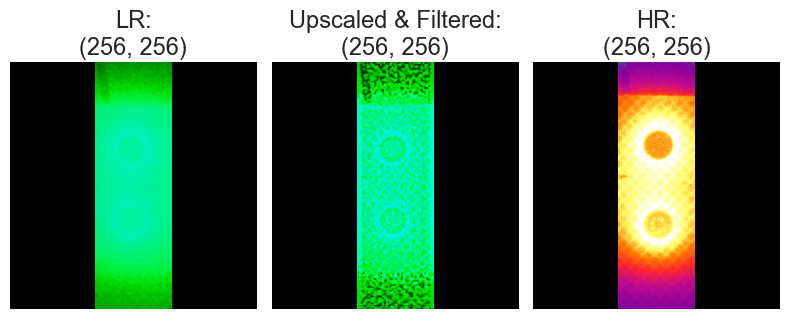

In [37]:
bicubic_upscale_filter(low_processed, plot=True,additionnal_image=(f"HR:\n{high_processed.size}",high_processed))

## Train

The training process is, of course, lengthy. We therefore prefer not to include it in the Jupyter notebook. It is executed with this bash command line. It is possible to modify a number of parameters, which are also presented in the `REAMDE.md` file.

In [38]:
#python train.py --dataroot ./datasets/ifr_images --name ifr_model_resnet_final --model cycle_gan  --init_type xavier --netG resnet_6blocks --n_epochs 60 --n_epochs_decay 240 --batch_size 8 --lambda_B 5 --pool_size 80 --preprocess none

### Loss plot
Once training is complete, you can view the images during epochs and obtain the loss log file. To view it, you can use the following command, which saves a png file (as explained in the `README.md` file). The code used is in the Python file `util/plot_loss_results.py`.

In [39]:
#python util/plot_loss_results.py --name ifr_model_resnet_final

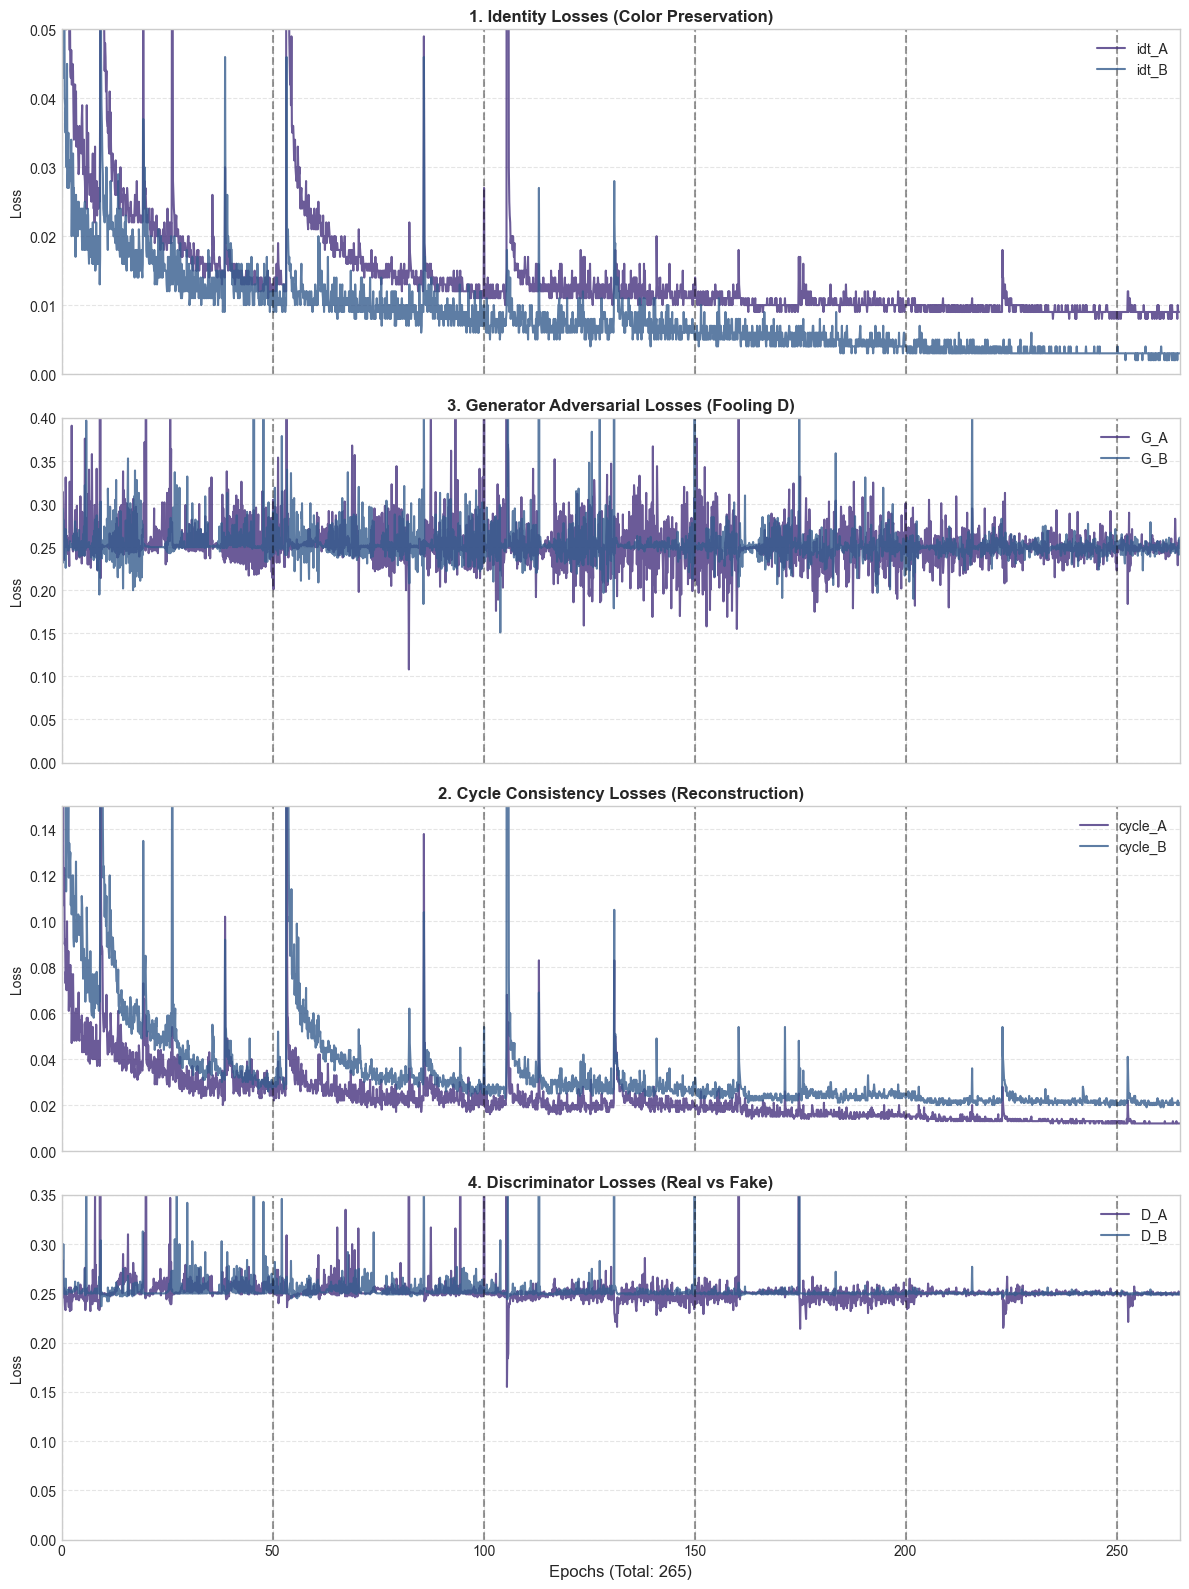

In [47]:
import re

filename = 'checkpoints/ifr_model_resnet_final/loss_log.txt' 

# Data storage
global_iterations = [] 
losses = {
    'D_A': [], 'G_A': [], 'cycle_A': [], 'idt_A': [],
    'D_B': [], 'G_B': [], 'cycle_B': [], 'idt_B': []
}

# Variables to handle epoch continuity (resetting iterations)
offset = 0
last_iter = 0
epoch_boundaries = [] # To store where new epochs begin

try:
    with open(filename, 'r') as f:
        for line in f:
            # Skip lines that don't contain iteration info
            if "iters:" not in line:
                continue

            # Extract current iteration number
            iter_match = re.search(r'iters:\s+(\d+)', line)
            if iter_match:
                current_iter = int(iter_match.group(1))
                
                # --- EPOCH DETECTION LOGIC ---
                # If the current iteration is smaller than the previous one,
                # it means a new epoch has started. We update the offset.
                if current_iter < last_iter:
                    offset += last_iter
                    epoch_boundaries.append(offset)
                
                # Calculate global iteration (absolute/cumulative)
                global_iter = current_iter + offset
                global_iterations.append(global_iter)
                
                # Update last known iteration
                last_iter = current_iter
            
                # Extract loss values
                for key in losses.keys():
                    loss_match = re.search(rf'{key}:\s+([\d\.]+)', line)
                    if loss_match:
                        losses[key].append(float(loss_match.group(1)))
                    else:
                        losses[key].append(None)

    # --- CONVERT ITERATIONS TO EPOCHS ---
    # The number of iterations in the first epoch determines the scale
    iters_per_epoch = epoch_boundaries[0]+80 if epoch_boundaries else (global_iterations[-1] if global_iterations else 1)
    # Convert the list of global iterations to a list of corresponding epoch numbers
    epochs = [i / iters_per_epoch for i in global_iterations]
    total_epochs = epochs[-1] if epochs else 0
    # --- PLOTTING ---
    # Create 4 stacked subplots sharing the same X-axis
    fig, (ax_id, ax_gen, ax_cycle, ax_disc) = plt.subplots(4, 1, figsize=(12, 16), sharex=True,sharey=False)

    # Define groups for each subplot
    group_id    = ['idt_A', 'idt_B']
    group_gen   = ['G_A', 'G_B']         # Pure adversarial loss
    group_cycle = ['cycle_A', 'cycle_B'] # Cycle consistency loss
    group_disc  = ['D_A', 'D_B']

    # Helper function to plot on a specific axis
    def plot_on_axis(ax, keys, max_val, title):
        for key in keys:
            values = losses[key]
            # Filter out None values to keep lines clean
            valid_data = [(e, v) for e, v in zip(epochs, values) if v is not None]
            if valid_data:
                valid_epochs, valid_vals = zip(*valid_data)
                ax.plot(valid_epochs, valid_vals, label=key, linewidth=1.5, alpha=0.8)
        
        ax.set_ylim(0, max_val)
        ax.set_xlim(0, total_epochs)
        
        # Draw vertical lines every 50 epochs
        for epoch_mark in range(0, int(total_epochs) + 1, 50):
            ax.axvline(x=epoch_mark, color='black', linestyle='--', alpha=0.4)
            
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_ylabel("Loss")
        ax.legend(loc='upper right')
        ax.grid(True, linestyle='--', alpha=0.5)

    # Plotting the 4 distinct levels with custom y-axis scales
    plot_on_axis(ax_id,    group_id,    0.05,   "1. Identity Losses (Color Preservation)")
    plot_on_axis(ax_cycle, group_cycle, 0.15,  "2. Cycle Consistency Losses (Reconstruction)")
    plot_on_axis(ax_gen,   group_gen,   0.4,   "3. Generator Adversarial Losses (Fooling D)")
    plot_on_axis(ax_disc,  group_disc,  0.35,   "4. Discriminator Losses (Real vs Fake)")

    # Set X-label only on the bottom graph
    ax_disc.set_xlabel(f"Epochs (Total: {int(total_epochs)})", fontsize=12)

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print(f"Error: The file '{filename}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")


## Test

For testing, use the following command: 

In [42]:
#python test.py  --dataroot ./datasets/ifr_images --name ifr_model_resnet_final 

The results can be viewed by browsing through the images generated in the `results` folder. Here is an example of the results obtained using our method: 

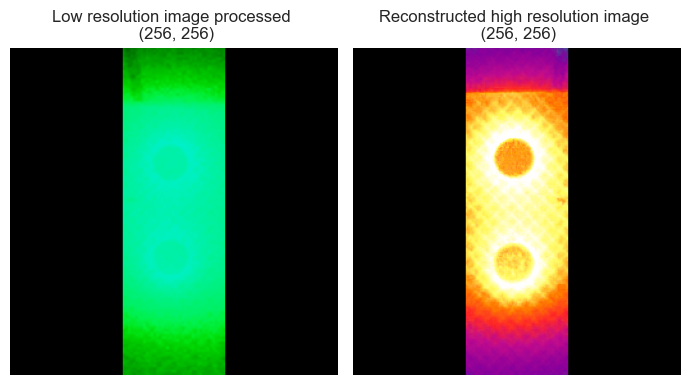

In [43]:
filepath = 'results/ifr_model_resnet_final/test_latest_A/images'

low_real = mpimg.imread(f"{filepath}/0_real.png")
high_fake = mpimg.imread(f"{filepath}/0_fake.png")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5))

ax1.imshow(low_real)
ax1.set_title(f"Low resolution image processed \n {low_processed.size}")
ax1.axis('off')  

ax2.imshow(high_fake)
ax2.set_title(f"Reconstructed high resolution image \n {high_processed.size}")
ax2.axis('off')

plt.tight_layout()
plt.show()

## Validation

Total circles detected: 2


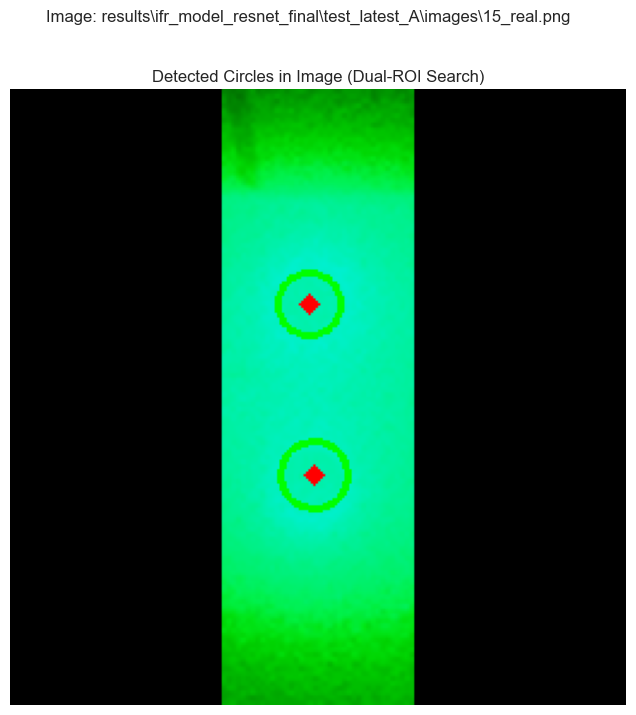

--- Circle Properties for the Image ---
Circle 1:
  Radius: 13 pixels
  Center: (124, 89)
Circle 2:
  Radius: 14 pixels
  Center: (126, 160)
Total circles detected: 2


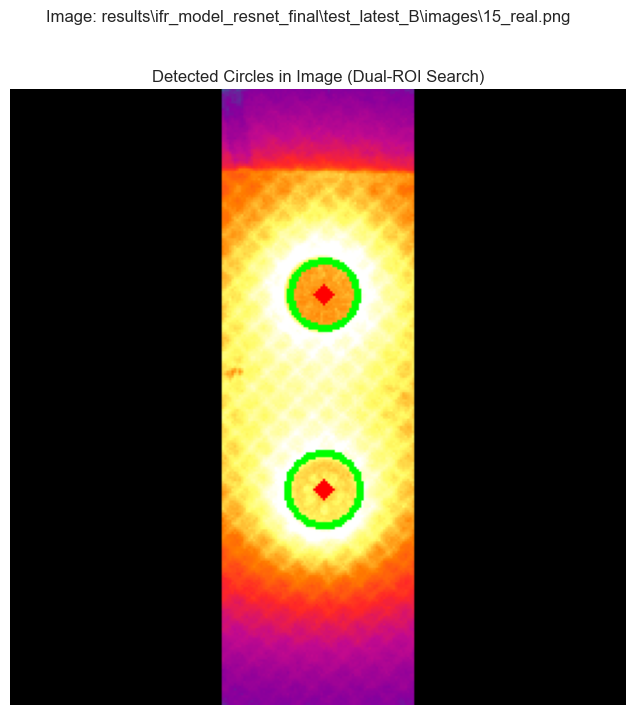

--- Circle Properties for the Image ---
Circle 1:
  Radius: 14 pixels
  Center: (130, 85)
Circle 2:
  Radius: 15 pixels
  Center: (130, 166)


In [44]:
from util.plot_validation import extract_circles, plot_distributions
import os
image_path_a = "results\\ifr_model_resnet_final\\test_latest_A\\images\\"
image_path_b = "results\\ifr_model_resnet_final\\test_latest_B\\images\\"

_ = extract_circles(os.path.join(image_path_a, '15_real.png'),image_type='low',plot=True)
_ = extract_circles(os.path.join(image_path_b, '15_real.png'),image_type='high',plot=True)

Processing real_low images from results\ifr_model_resnet_final\test_latest_A\images\...
No circle detected in image results\ifr_model_resnet_final\test_latest_A\images\5_real.png
Processing fake_high images from results\ifr_model_resnet_final\test_latest_A\images\...
Processing real_high images from results\ifr_model_resnet_final\test_latest_B\images\...
Processing fake_low images from results\ifr_model_resnet_final\test_latest_B\images\...

--- Data Extraction Complete ---
real_low: Found 77 circles.
fake_high: Found 100 circles.
real_high: Found 100 circles.
fake_low: Found 86 circles.


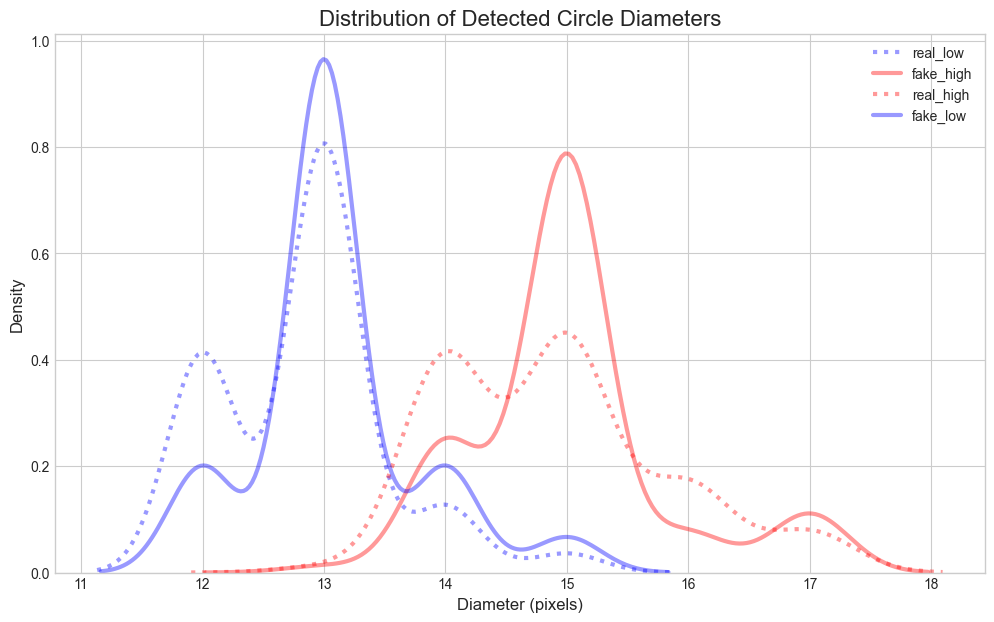

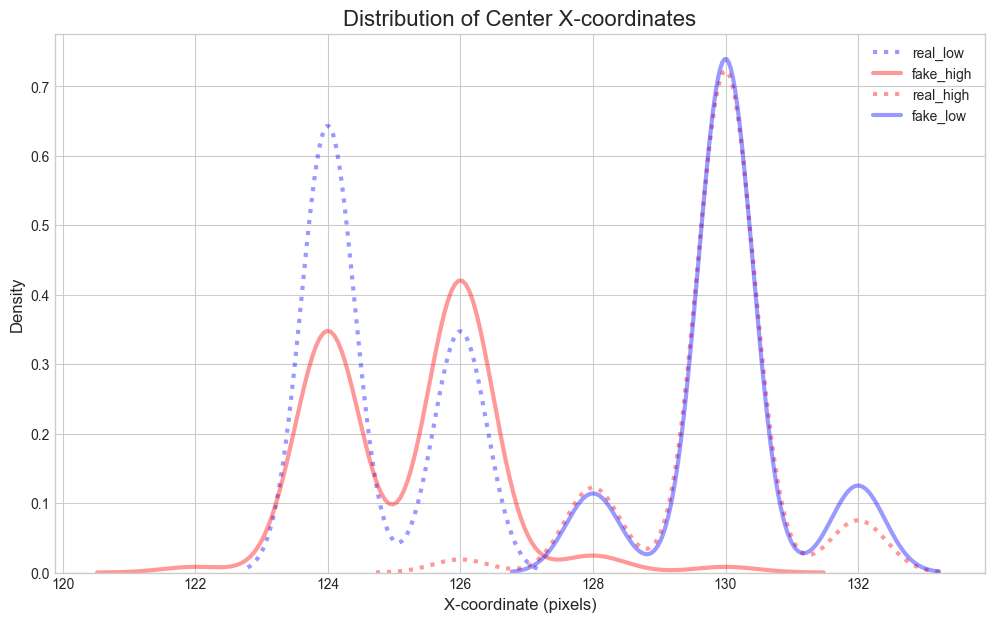

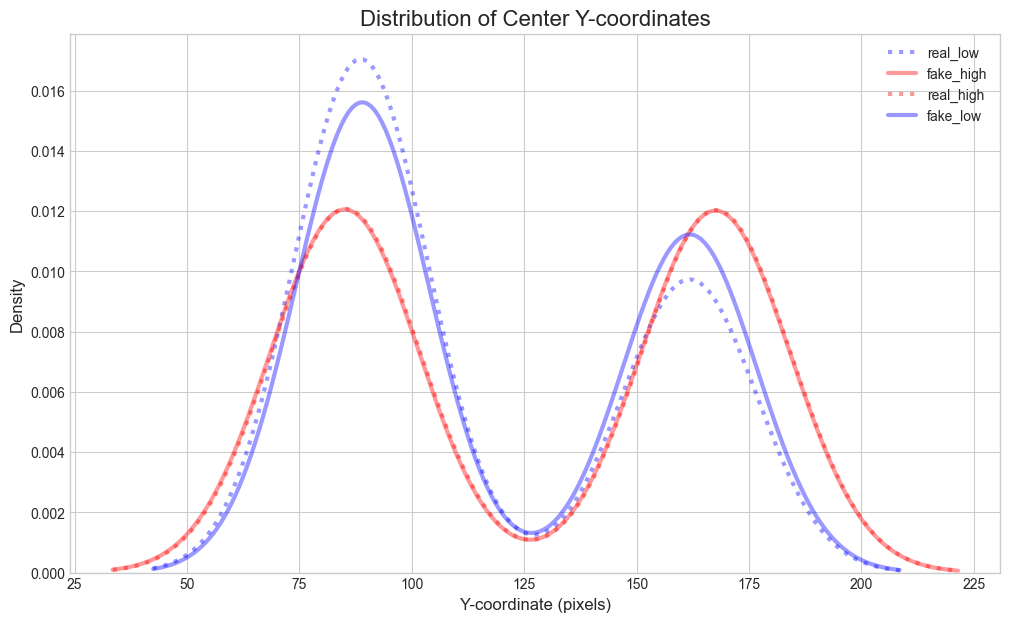

In [45]:
plot_distributions(low_to_high=image_path_a,high_to_low=image_path_b)

# Appendix

Here are the losses of the imagenet model :

![Image Net Losses](images/imagenet_losses.png)